# Implementation of Adversarial Reprogramming for CIFAR 10

Using the multiple output label remapping

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from pylab import *
from models import *

In [2]:
rcParams['figure.figsize'] = 18,7
rcParams['axes.grid'] = True
rcParams['font.size'] = 15
style.use('dark_background')

In [3]:
from pytorch_utils.train_utils import *
from pytorch_utils.updaters import *

In [4]:
from torchvision.models import *
import torchvision

In [5]:
torch.backends.cudnn.benchmark=True

In [6]:
DEVICE = torch.device('cpu')

# Get the model

In [7]:
model = resnet18(pretrained=True)

In [8]:
model.to(DEVICE)
model.eval();

In [9]:
params = nn.utils.parameters_to_vector(model.parameters())
params.shape

torch.Size([11689512])

In [10]:
test = torch.rand(1,3,224,224).to(DEVICE)
test.shape

torch.Size([1, 3, 224, 224])

In [11]:
with torch.no_grad():
    out = model(test)

In [12]:
out.shape

torch.Size([1, 1000])

## Get the data

In [13]:
from torchvision.datasets import *
from torchvision.transforms import *

In [14]:
transforms = Compose([
                      Resize((224,224)),
                      ToTensor()
                     ])

In [15]:
total_train_cifar = CIFAR10('/CIFAR10',download=True,transform=transforms)
test_cifar = CIFAR10('/CIFAR10',train=False,transform=transforms)

Files already downloaded and verified


Splitting:

In [16]:
training_number = len(total_train_cifar)
val_split = 0.1

train_num = int(training_number*(1-val_split))
val_num = int(training_number*val_split)

train_cifar, val_cifar = torch.utils.data.dataset.random_split(total_train_cifar, 
                [train_num, val_num])

In [17]:
batch_size = 32
train_loader = DataLoader(train_cifar, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_cifar, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_cifar, batch_size=batch_size,shuffle=True)
print(len(train_loader))

1407


In [18]:
model_reprog = ReprogramTanh(model, (224,224), 1000).to(DEVICE)

True


In [19]:
model_reprog.weight.data.fill_(0);

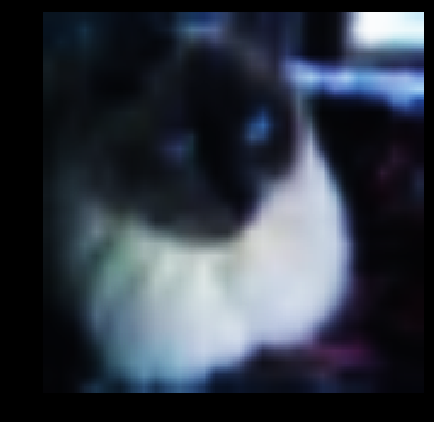

In [20]:
model_reprog(train_cifar[randint(1000)][0].view(1,3,224,224).to(DEVICE), plot_inp=True);

In [21]:
test_optimizer = optim.Adam([model_reprog.weight], lr=0.001, weight_decay=0)

loader = iter(train_loader)

In [ ]:
%%timeit

# torch.cuda.synchronize()
# t0 = time.perf_counter()
input_test = next(loader)
criterion = nn.CrossEntropyLoss()
output = model_reprog(input_test[0].to(DEVICE))
loss = criterion(output, input_test[1].to(DEVICE))
test_optimizer.zero_grad()
loss.backward()
# print(model_reprog.weight.grad.sum())
test_optimizer.step()
# torch.cuda.synchronize() 
# print('Time taken',time.perf_counter()-t0)

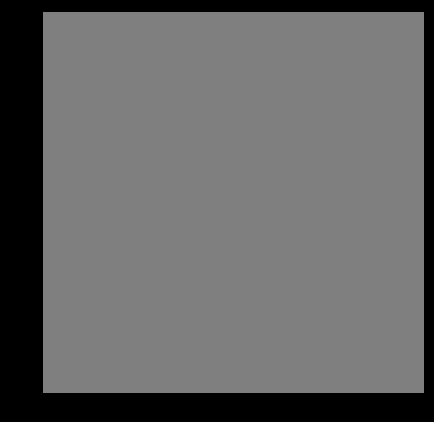

In [22]:
axis('off')
imshow(F.sigmoid(2*model_reprog.weight.data).detach().cpu().numpy().transpose([1,2,0]))

In [23]:
model_reprog = ReprogramTanh(model, (224,224), 1000).to(DEVICE)

True


In [24]:
model_reprog.weight.data.fill_(0);

### Load the mapping obtained from the LabelRemapping notebook

In [25]:
h_res18_cif = torch.load('HISTS_CIFAR_resnet18_normtanh.tensor')
resnet18_mapping = argmax(h_res18_cif, axis=0)

In [26]:
LABEL_MAPPING1k = resnet18_mapping

# Train functions

Sorry for using globals

In [27]:
from skimage.filters import gaussian

In [28]:
glob_blur_sigma = 0.3
glob_blur_sigma_factor = 0.5

In [29]:
def gaussian_kernel(size=5, sigma=0.7):
    """Returns a 2D Gaussian kernel.
    Parameters
    ----------
    size : float, the kernel size (will be square)

    sigma : float, the sigma Gaussian parameter

    Returns
    -------
    out : array, shape = (size, size)
      an array with the centered gaussian kernel
    """
    x = np.linspace(-1,1,size)
    x /= np.sqrt(2)*sigma
    x2 = x**2
    kernel = np.exp(- x2[:, None] - x2[None, :])
    kernel = kernel / kernel.sum()
    return np.expand_dims(kernel, 0)

In [30]:
def blur(weight, sigma, size=5, padding=2):
    blur_kernel = torch.Tensor(gaussian_kernel(size=size, sigma=sigma)).to(DEVICE).repeat((1,1,1,1))
#     print(blur_kernel.requires_grad)
    weight[0] = F.conv2d(weight[0].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    weight[1] = F.conv2d(weight[1].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    weight[2] = F.conv2d(weight[2].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    
    

In [31]:
def trainOnBatch(model,batch,optimizer):
    
    # batch is tuple containing (tensor of images, tensor of labels)
    outputs = model(batch[0].to(DEVICE)) # forward pass
    probabs_model = F.softmax(outputs, dim=1)
    
#     probabs_mapped = torch.bincount(LABEL_MAPPING1k, probabs_model)
    probabs_mapped = torch.zeros(batch[0].size()[0], 10).to(DEVICE)
#     print(LABEL_MAPPING1k.shape)
    for i in range(10):
        a = probabs_model[:,where(LABEL_MAPPING1k==i)]
#         print(a.shape)
        probabs_mapped[:,i] = a.squeeze().sum(dim=1)
    
    log_probabs = torch.log(probabs_mapped)
    # compute loss
    criterion = nn.NLLLoss()
    loss = criterion(log_probabs,batch[1].to(DEVICE))
    
    # backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    
    old = model.weight.grad.cpu().detach().numpy()[:]
    
    s1 = old.std()
    
    #     blur grad
    with torch.no_grad():
        blur(model.weight.grad, sigma=glob_blur_sigma, size=5, padding=2)
    
    new = model.weight.grad.cpu().detach().numpy()
    
    s2 = new.std()

#     if s2==s1:
#         print('old and new same')
        
    optimizer.step()
    
#     blur weight
    with torch.no_grad():
        blur(model.weight, sigma=glob_blur_sigma, size=5, padding=2)


    # compute and return metrics
    loss = loss.detach().cpu().numpy()
    acc = accuracy(log_probabs, batch[1].to(DEVICE))
    
    return loss, acc

In [32]:
optimizer = optim.Adam([model_reprog.weight], lr=0.005, weight_decay=0.0)
glob_epoch_count = 0
epochs_to_zero_weight_decay = 3
epochs_to_reduce_lr = 20
glob_lr_decay_factor = 0.95

In [33]:
def callback(model, val_loader):
    with torch.no_grad(): # dont compute gradients
        global glob_epoch_count, glob_blur_sigma, glob_blur_sigma_factor, epochs_to_zero_weight_decay, epochs_to_reduce_lr
        global glob_lr_decay_factor
        glob_epoch_count +=1
        glob_blur_sigma *= glob_blur_sigma_factor
        
        criterion = nn.NLLLoss()
        
        model.eval() # eval mode
        
        batches = len(val_loader)
        loss=0
        acc=0
        for batch in val_loader:
            outputs = model(batch[0].to(DEVICE))
            probabs_model = F.softmax(outputs, dim=1)
    
#             probabs_mapped = torch.bincount(LABEL_MAPPING1k, probabs_model)
            
            probabs_mapped = torch.zeros(batch[0].size()[0], 10).to(DEVICE)
        #     print(LABEL_MAPPING1k.shape)
            for i in range(10):
                a = probabs_model[:,where(LABEL_MAPPING1k==i)]
        #         print(a.shape)
                probabs_mapped[:,i] = a.squeeze().sum(dim=1)
    
            log_probabs = torch.log(probabs_mapped)
            # compute loss
            loss += criterion(log_probabs,batch[1].to(DEVICE))
            acc += accuracy(log_probabs,batch[1].to(DEVICE))
        
        # find average loss and accuracy over whole vaildation set
        loss/= batches
        acc /= batches
        
        if glob_epoch_count==epochs_to_zero_weight_decay:
            print('weight decays set to 0')
            for p in optimizer.param_groups:
                p['weight_decay']=0
                
#         if glob_epoch_count==epochs_to_reduce_lr:
#             print('lrs set to 0.001')
#             for p in optimizer.param_groups:
#                 p['lr']=0.001
        
        for p in optimizer.param_groups:
                p['lr']*= glob_lr_decay_factor
            
        model.train() # go back to train mode
        
        # return metrics
        return loss.cpu().numpy(), acc

In [34]:
trainer = Trainer(model_reprog, trainOnBatch, callback=callback, save_dir='cifar_save_dir')

In [35]:
trainer.setup_metrics(batch_metric_names=['loss','acc'], # trainOnBatch returns training loss and acc
                      callback_metric_names=['val_loss','val_acc'], # callback returns validation loss and acc
                      batch_metric_updaters=[averager, averager], # average the batch metrics over the epoch
                      save_name_metrics=['val_acc'], # Use the validation acc in checkpoint save names
                      fig_grid=(1,2), # 1 row, 2 cols
                      plot_grouping=[
                          ['loss','val_loss'], # first subplot for losses
                          ['acc','val_acc'] # second subplot for accuracies
                      ])

In [36]:
nn.utils.parameters_to_vector(model_reprog.parameters()).size()

torch.Size([150528])

## Run this cell to train

In [ ]:
metrics = trainer.loop(epochs=200, 
                       train_loader=train_loader,
                       optimizer=optimizer, 
                       val_loader=val_loader,
                       update_interval=1,
                       old_metrics=None)

In [ ]:
img = model_reprog.weight.data

In [ ]:
axis('off')
imshow((F.tanh(img).detach().cpu().numpy().transpose([1,2,0])+1)/2)